In [88]:
import tensorflow as tf
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

class PolicyNetwork:

    def __init__(self, input_shape, output_shape, discount=0.9, learning_rate=3e-4):

        self.model = tf.keras.models.Sequential([
                            tf.keras.layers.Dense(16, activation='relu', input_shape=input_shape),
                            tf.keras.layers.Dense(32, activation='relu'),
                            tf.keras.layers.Dense(output_shape, activation='softmax')])
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.discount = discount
        self.num_actions = output_shape

    def forward(self, state):
        state = tf.convert_to_tensor(state)
        state = tf.expand_dims(state, 0)
        return self.model(state)
    
    def get_action(self, state):
        
        probs = self.forward(state)
        action = np.random.choice(self.num_actions, p=tf.squeeze(probs).numpy())
        
        log_prob = tf.math.log(tf.squeeze(probs)[action])
        
        return action, log_prob

    def train_episode(self, env, max_steps, render=False):

        state = env.reset()

        log_probs = []
        rewards = []

        with tf.GradientTape() as tape:
            
            for step in range(max_steps):
                
                action, log_prob = self.get_action(state)

                state, reward, done, _ = env.step(action)
                rewards.append(reward)
                log_probs.append(log_prob)

                if done:
                    discounted_rewards = []
                    for t in range(len(rewards)):
                        Gt = 0
                        pw = 0
                        for r in rewards[t:]:
                            Gt += (self.discount**pw) * r
                            pw += 1
                        discounted_rewards.append(Gt)

                    discounted_rewards = np.array(discounted_rewards)
                    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9)
                    discounted_rewards = discounted_rewards.tolist()
                    policy_loss = 0
                    for log_prob, Gt in zip(log_probs, discounted_rewards):
                        policy_loss -= log_prob * Gt
                    break
        
        if done:
            policy_gradients = tape.gradient(policy_loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(policy_gradients, self.model.trainable_variables))

        return rewards
        

if __name__ == '__main__':

    env = gym.make('CartPole-v0')

    episode_rewards = []
    agent = PolicyNetwork(env.observation_space.shape, env.action_space.n)
    for episode in range(1, 5000):
        try:
            display.clear_output(wait=True)
            if episode % 100 == 0:
                rewards = agent.train_episode(env, 10000, True)    
            else:
                rewards = agent.train_episode(env, 10000)
            print(f"In Episode : {episode}")
            
            episode_rewards.append(sum(rewards))
            print(np.mean(episode_rewards))

        except KeyboardInterrupt:
            agent.model.save("Model_new.h5")
            plt.plot(list(range(len(episode_rewards))), episode_rewards)
            plt.show()
            time.sleep(5)
   


In Episode : 4999
148.95779155831167


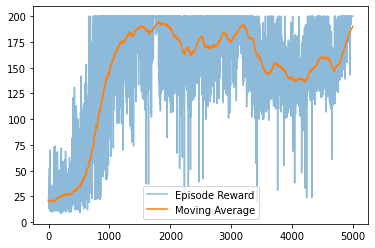

In [92]:
prev = 0
mva = []

k = 2 / (201)

for el in episode_rewards:

    if prev != 0:
        pres = prev * (1 - k) + el * k
    else:
        pres = el
    prev = pres
    mva.append(pres)
plt.plot(list(range(len(episode_rewards))), episode_rewards, alpha=0.5, label="Episode Reward")
plt.plot(list(range(len(mva))), mva, label="Moving Average")
plt.legend()